In [101]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from geopy import distance
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max.columns',50)

In [10]:
city = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/raw/worldcities.csv')
bnb = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/raw/train.csv')

In [11]:
bnb.city.unique()

array(['NYC', 'SF', 'DC', 'LA', 'Chicago', 'Boston'], dtype=object)

In [27]:
city_df = city[city['id'].astype('str').isin(['1840034016', '1840020491', '1840000494', 
                                '1840006060', '1840000455', '1840021543'])]
city_df = city_df.rename(columns={'id':'city_id', 'city':'city_name'})
city_df['city_id'] = city_df['city_id'].astype('str')

bnb_city_id = {'NYC':'1840034016', 'SF':'1840021543', 'DC':'1840006060', 
 'LA':'1840020491', 'Chicago':'1840000494', 'Boston':'1840000455'}

bnb['city_id'] = bnb['city'].map(bnb_city_id)

train = pd.merge(bnb, city_df, how='left', on='city_id')

In [28]:
def dist_city_center(prop_lat, prop_lon, city_lat, city_lon):
    prop_coords = (prop_lat, prop_lon)
    city_coords = (city_lat, city_lon)
    dist = distance.great_circle(prop_coords, city_coords).miles
    return dist

In [29]:
train['cc_dist'] = train.apply(lambda x: dist_city_center(x.latitude, x.longitude, x.lat, x.lng), axis=1)

In [30]:

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
#     m = km * 0.621371
    
    return km

In [31]:
def num_close_airbnbs(y, df, dist_thresh):
    df['cur_lat'] = y.latitude
    df['cur_lon'] = y.longitude
    df['rel_dist'] = haversine_np(df['cur_lon'], df['cur_lat'], df['longitude'], df['latitude'])
    num_close = df[df['rel_dist']<=dist_thresh]
    return len(num_close)-1

In [32]:
train['num_bnb_1km'] = train.apply(lambda y: num_close_airbnbs(y, train, 1), axis=1)

# train['num_bnb_3mi'] = train.apply(lambda y: num_close_airbnbs(y, train, 3), axis=1)
# train['num_bnb_5mi'] = train.apply(lambda y: num_close_airbnbs(y, train, 5), axis=1)
# train['num_bnb_10mi'] = train.apply(lambda y: num_close_airbnbs(y, train, 10), axis=1)

train = train.drop(columns=['cur_lat', 'cur_lon', 'rel_dist'])

In [33]:
# Total number of rows and columns
train.shape

(74111, 42)

In [34]:
# Rows containing duplicate data
duplicate_rows_train = train[train.duplicated()]
print('number of duplicate rows:', duplicate_rows_train.shape)

train = train.drop_duplicates()

number of duplicate rows: (0, 42)


In [35]:
## Finding the null values.
print(train.isnull().sum())

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
city_id                       0
city_name                     0
city_asc

In [63]:
train.to_csv('/Users/guanlxy/ids-705-final-project/data/processed/train.csv')

In [107]:
df = train.copy()
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,city_id,city_name,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,cc_dist,num_bnb_1km
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,1840034016,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0,3.498384,272
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,1840034016,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0,5.991584,1400
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,1840034016,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0,7.925215,891
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,1840021543,San Francisco,San Francisco,37.7562,-122.4430,United States,US,USA,California,NaN,3592294.0,1.256540,666
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0,1840006060,Washington,Washington,38.9047,-77.0163,United States,US,USA,District of Columbia,primary,5379184.0,1.748733,727


In [108]:
df = df.where(pd.notnull(df), None)

In [112]:
df.property_type.astype("category")
df.room_type.astype('category')
df.cancellation_policy.astype('category')
df.cleaning_fee.astype('category')
df.city.astype('category')
df.cleaning_fee.astype('category')
df.host_has_profile_pic.astype('category')
df.host_identity_verified.astype('category')
df.instant_bookable.astype('category')
df.log_price.astype('float')
df.accommodates.astype('float')
df.bathrooms.astype('float')
#df.host_response_rate.astype('float')
df.review_scores_rating.astype('float')
df.bedrooms.astype('float')
df.beds.astype('float')
df.cc_dist.astype('float')

0         3.498384
1         5.991584
2         7.925215
3         1.256540
4         1.748733
           ...    
74106     1.269807
74107    16.756184
74108     1.256166
74109     4.987378
74110    27.299106
Name: cc_dist, Length: 74111, dtype: float64

In [113]:
df.head(2)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,city_id,city_name,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,cc_dist,num_bnb_1km
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,None,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,1840034016,New York,New York,40.6943,-73.9249,United States,US,USA,New York,None,18713220,3.498384,272
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.98904,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,1840034016,New York,New York,40.6943,-73.9249,United States,US,USA,New York,None,18713220,5.991584,1400


In [114]:
heatmapdf = df.copy()
heatmapdf.drop(columns=['id','amenities','description','first_review','host_since','last_review',
                        'name','neighbourhood','thumbnail_url','city_id','city_name','country',
                       'iso2','iso3','admin_name','admin_name'])

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,city_ascii,lat,lng,capital,population,cc_dist,num_bnb_1km
0,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,t,t,None,f,40.696524,-73.991617,2,100.0,11201,1.0,1.0,New York,40.6943,-73.9249,None,18713220,3.498384,272
1,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,t,f,100%,t,40.766115,-73.98904,6,93.0,10019,3.0,3.0,New York,40.6943,-73.9249,None,18713220,5.991584,1400
2,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,t,t,100%,t,40.80811,-73.943756,10,92.0,10027,1.0,3.0,New York,40.6943,-73.9249,None,18713220,7.925215,891
3,6.620073,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,t,t,None,f,37.772004,-122.431619,0,None,94117.0,2.0,2.0,San Francisco,37.7562,-122.443,None,3592294,1.25654,666
4,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,t,t,100%,t,38.925627,-77.034596,4,40.0,20009,0.0,1.0,Washington,38.9047,-77.0163,primary,5379184,1.748733,727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,4.60517,Apartment,Private room,1,1.0,Real Bed,flexible,False,NYC,t,t,None,f,40.709025,-73.939405,0,None,11206.0,1.0,1.0,New York,40.6943,-73.9249,None,18713220,1.269807,1103
74107,5.043425,Apartment,Entire home/apt,4,2.0,Real Bed,moderate,True,LA,t,f,100%,f,33.871549,-118.396053,16,93.0,90254,2.0,4.0,Los Angeles,34.1139,-118.4068,None,12750807,16.756184,46
74108,5.220356,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,t,t,100%,t,40.706749,-73.942377,43,94.0,11206.0,2.0,2.0,New York,40.6943,-73.9249,None,18713220,1.256166,1160
74109,5.273,Apartment,Entire home/apt,2,1.0,Real Bed,strict,True,NYC,t,f,100%,t,40.738535,-74.000157,0,None,10011,0.0,2.0,New York,40.6943,-73.9249,None,18713220,4.987378,1340


,id,accommodates,cleaning_fee,number_of_reviews,population,num_bnb_1km
id,1.000000,-0.005759,-0.003059,0.002945,0.004404,0.001162
accommodates,-0.005759,1.000000,0.182306,0.041964,-0.109283,-0.090805
cleaning_fee,-0.003059,0.182306,1.000000,0.110204,-0.021016,-0.004124
number_of_reviews,0.002945,0.041964,0.110204,1.000000,-0.075563,-0.010675
population,0.004404,-0.109283,-0.021016,-0.075563,1.000000,0.466330
num_bnb_1km,0.001162,-0.090805,-0.004124,-0.010675,0.466330,1.000000


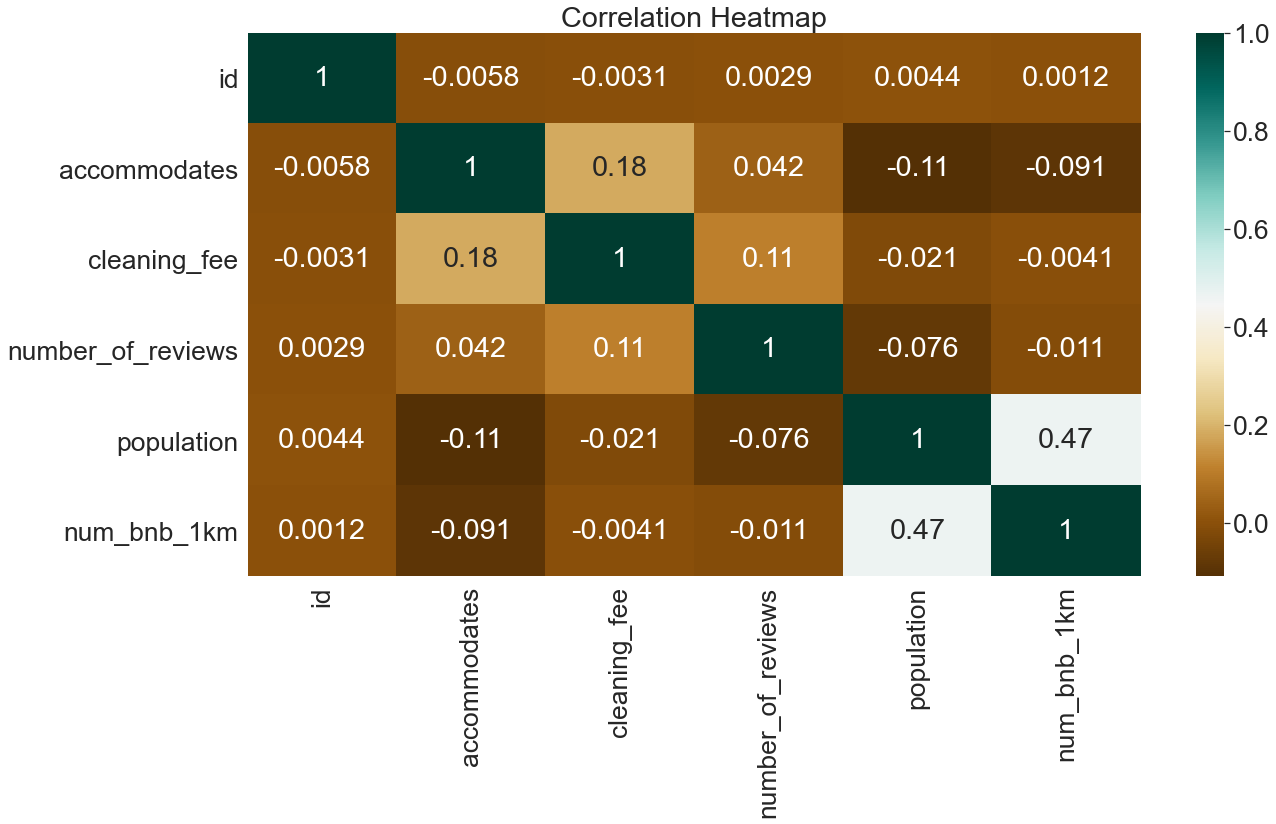

In [150]:
plt.figure(figsize=(20,10))
c= heatmapdf.corr()
sns.set(font_scale=2.4)
sns.heatmap(c,cmap='BrBG',annot=True).set_title('Correlation Heatmap')
c

In [105]:
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

In [116]:
heatmapdf.head(2)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,city_id,city_name,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,cc_dist,num_bnb_1km
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,None,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,1840034016,New York,New York,40.6943,-73.9249,United States,US,USA,New York,None,18713220,3.498384,272
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.98904,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,1840034016,New York,New York,40.6943,-73.9249,United States,US,USA,New York,None,18713220,5.991584,1400


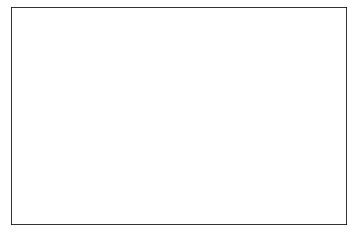

In [119]:
columns = ['property_type','room_type','cancellation_policy','host_has_profile_pic',
          'host_identity_verified','instant_bookable',]

corr = heatmapdf[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

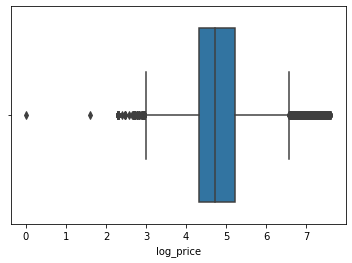

In [124]:
# detect outliers
sns.boxplot(x=df['log_price'])

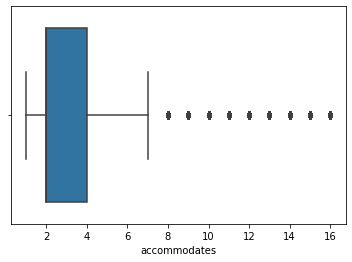

In [125]:
sns.boxplot(x=df['accommodates'])

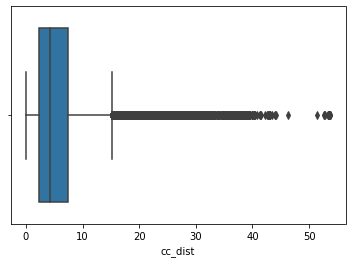

In [128]:
sns.boxplot(x=df['cc_dist'])

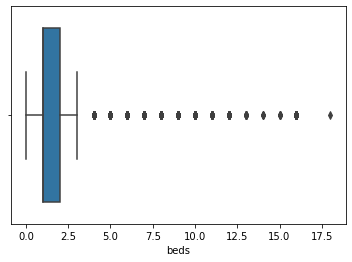

In [127]:
sns.boxplot(x=df['beds'])

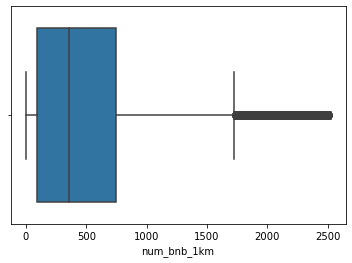

In [129]:
sns.boxplot(x=df['num_bnb_1km'])

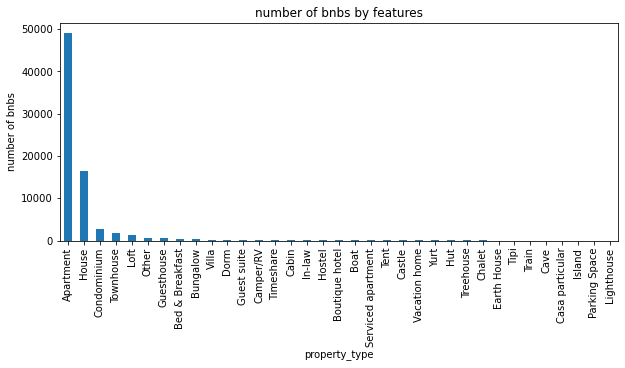

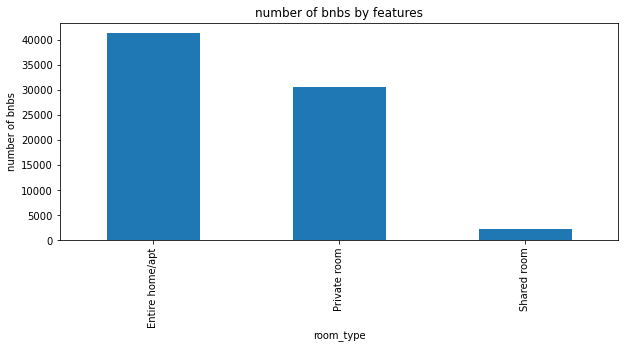

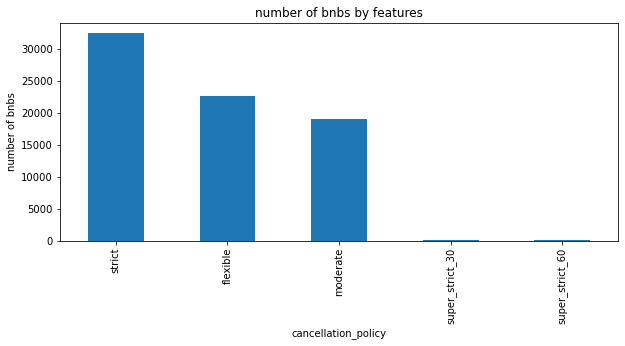

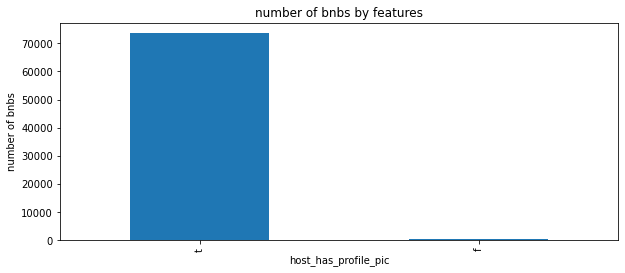

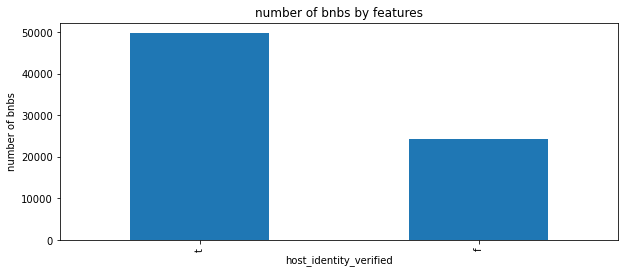

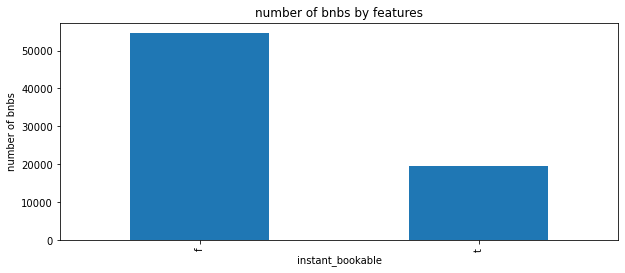

In [136]:
for i in columns:
    df[i].value_counts().nlargest(40).plot(kind='bar', figsize=(10,4))
    plt.title('number of bnbs by features')
    plt.ylabel('number of bnbs')
    plt.xlabel(i)
    plt.show()

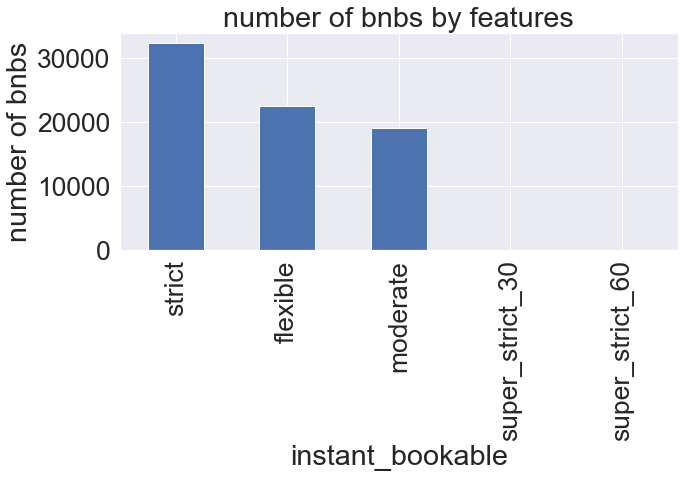

In [151]:
df.cancellation_policy.value_counts().nlargest(40).plot(kind='bar', figsize=(10,4))
plt.title('number of bnbs by features')
plt.ylabel('number of bnbs')
plt.xlabel(i)
plt.show()